In [1]:
!pip install rioxarray rasterio


In [2]:
import xarray as xr

# Replace with the path to your NetCDF file if it's not in the same directory:
filename = "CONUS-MT-2021.r0.0.nc"

# 1. Open the NetCDF file using xarray
ds = xr.open_dataset(filename)

# 2. Print an overview of the entire dataset (dimensions, variables, attributes)
print("=== Dataset Overview ===")
print(ds)

# 3. Show the data variables present in the file (e.g., conductivity/resistivity)
print("\n=== Data Variables ===")
print(ds.data_vars)

# 4. Print more details about each data variable
print("\n=== Detailed Info for Each Variable ===")
for var_name in ds.data_vars:
    print(f"\n--- Variable: {var_name} ---")
    print(ds[var_name])

# 5. (Optional) Explore the coordinate variables (e.g., lat, lon, depth)
print("\n=== Coordinate Variables ===")
for coord_name in ds.coords:
    print(f"\n--- Coordinate: {coord_name} ---")
    print(ds[coord_name])

# 6. Close the dataset once you're done
ds.close()


C:\Users\gargi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


=== Dataset Overview ===
<xarray.Dataset> Size: 80MB
Dimensions:      (longitude: 650, latitude: 278, depth: 111)
Coordinates:
  * longitude    (longitude) float32 3kB -129.9 -129.9 -129.8 ... -65.15 -65.05
  * latitude     (latitude) float32 1kB 23.15 23.25 23.35 ... 50.65 50.75 50.85
  * depth        (depth) float32 444B 0.05 0.1532 0.2632 ... 1.727e+03 2.075e+03
Data variables:
    log_10sigma  (depth, latitude, longitude) float32 80MB ...
Attributes: (12/31)
    title:                         High resolution electrical conductivity va...
    id:                            CONUS-MT-2021
    data_revision:                 r0.0
    summary:                       To compile the global and regional electri...
    keywords:                      global, regional, continental-scale, elect...
    Conventions:                   CF-1.0
    ...                            ...
    geospatial_lon_resolution:     0.10
    geospatial_vertical_min:          0
    geospatial_vertical_max:       2285


In [1]:
import xarray as xr
import numpy as np
import rioxarray  # For exporting to GeoTIFF
import matplotlib.pyplot as plt
import os

# Load the dataset
filename = "CONUS-MT-2021.r0.0.nc"
ds = xr.open_dataset(filename)

# Define depth levels to export
depth_levels = [5, 10, 50, 100]  # in km
output_files = []

# Set explicit path to your Downloads folder
downloads_path = r"C:\Users\gargi\Downloads"

# Choose a colormap with a smooth gradient from yellow to blue
colormap = "cividis"  # "cividis" is perceptually uniform and transitions smoothly

# Loop through each depth and save a GeoTIFF
for depth in depth_levels:
    # Select the closest depth slice in log scale (already in dataset)
    log_conductivity_slice = ds["log_10sigma"].sel(depth=depth, method="nearest")

    # Ensure the data has spatial metadata for GIS (latitude/longitude CRS)
    log_conductivity_slice = log_conductivity_slice.rio.write_crs("EPSG:4326")

    # Save file in Downloads folder
    output_filename = os.path.join(downloads_path, f"log_conductivity_{int(depth)}km.tif")
    log_conductivity_slice.rio.to_raster(output_filename)
    output_files.append(output_filename)

    # Plot the exported slice in logarithmic scale with a yellow-to-blue gradient
    plt.figure(figsize=(8, 6))
    img = log_conductivity_slice.plot(cmap=colormap, add_colorbar=True)  # Use "cividis" for yellow-to-blue
    img.colorbar.set_label("log10(Conductivity) [S/m]")  # Proper colorbar labeling
    plt.title(f"Log(Conductivity) at {depth} km depth")
    plt.show()

# Close dataset
ds.close()

# Display output file names
print(f"✅ Successfully saved in Downloads: {', '.join(output_files)}")


C:\Users\gargi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


CPLE_AppDefinedError: Deleting C:\Users\gargi\Downloads\log_conductivity_5km.tif failed: Permission denied

In [8]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree

# === Load the Moho depth dataset ===
moho_file_path = "C:/Users/gargi/Downloads/US_Canada_Moho_Project.xlsx"
df_moho = pd.read_excel(moho_file_path, sheet_name="US_Canada_Moho_Project")

# Rename columns for clarity
df_moho = df_moho.rename(columns={"X": "Longitude", "Y": "Latitude", "Mode Depth": "Moho_Depth"})

# === Load the CONUS MT NetCDF dataset ===
netcdf_file_path = "C:/Users/gargi/Downloads/CONUS-MT-2021.r0.0.nc"
ds = xr.open_dataset(netcdf_file_path)

# Extract coordinate arrays
latitudes = ds.latitude.values
longitudes = ds.longitude.values
depths = ds.depth.values  # Depth values from the NetCDF file

# Extract log10 conductivity data
log_conductivity = ds.log_10sigma.values  # Shape: (depth, lat, lon)

# === Create KDTree for fast lat/lon matching ===
grid_points = np.array(np.meshgrid(latitudes, longitudes)).T.reshape(-1, 2)  # Flatten lat/lon grid
tree = cKDTree(grid_points)

# Find the nearest lat/lon match for each Moho point
moho_points = df_moho[["Latitude", "Longitude"]].values
distances, indices = tree.query(moho_points)

# Get the corresponding lat/lon indices
lat_idx, lon_idx = np.unravel_index(indices, (len(latitudes), len(longitudes)))

# === Find the closest depth match for each Moho depth ===
moho_depths = df_moho["Moho_Depth"].values
closest_depth_indices = np.abs(depths[:, None] - moho_depths).argmin(axis=0)  # Find nearest depth index

# Extract matched conductivity values
matched_conductivity = log_conductivity[closest_depth_indices, lat_idx, lon_idx]

# === Create and Save New Excel File ===
df_moho["Matched_Depth"] = depths[closest_depth_indices]
df_moho["Matched_Conductivity"] = matched_conductivity

output_excel_path = "C:/Users/gargi/Downloads/Moho_Conductivity_Matched.xlsx"
df_moho.to_excel(output_excel_path, index=False)

print(f"New Excel file saved at: {output_excel_path}")

New Excel file saved at: C:/Users/gargi/Downloads/Moho_Conductivity_Matched.xlsx


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray  # GeoTIFF Export
import os
from scipy.interpolate import griddata

# === Define File Paths ===
downloads_path = r"C:\Users\gargi\Downloads"
matched_file_path = os.path.join(downloads_path, "Moho_Conductivity_Matched.xlsx")
tiff_filename = os.path.join(downloads_path, "Moho_Conductivity_Layer.tif")

# === Load the Matched Moho Conductivity Data ===
df = pd.read_excel(matched_file_path)

# === Load CONUS MT Dataset to Match Its Grid ===
netcdf_file_path = os.path.join(downloads_path, "CONUS-MT-2021.r0.0.nc")
ds_mt = xr.open_dataset(netcdf_file_path)

# Extract exact grid size from the NetCDF file
latitudes = np.linspace(df["Latitude"].min(), df["Latitude"].max(), ds_mt.dims['latitude'])
longitudes = np.linspace(df["Longitude"].min(), df["Longitude"].max(), ds_mt.dims['longitude'])
grid_lon, grid_lat = np.meshgrid(longitudes, latitudes)

# === Interpolate Moho Conductivity Data Onto This Grid ===
grid_conductivity = griddata(
    (df["Longitude"], df["Latitude"]),  # Original scattered points
    df["Matched_Conductivity"],        # Values to interpolate
    (grid_lon, grid_lat),              # Target grid
    method="cubic"                      # Smooth interpolation
)

# === Mask Out Extrapolated Areas ===
valid_mask = griddata(
    (df["Longitude"], df["Latitude"]),
    np.ones_like(df["Matched_Conductivity"]),
    (grid_lon, grid_lat),
    method="nearest"
)

grid_conductivity[np.isnan(valid_mask)] = np.nan

# === Convert to Xarray Dataset ===
ds_moho = xr.Dataset(
    {
        "Moho_Conductivity": (["latitude", "longitude"], grid_conductivity)
    },
    coords={
        "latitude": latitudes,
        "longitude": longitudes
    }
)

# Assign correct CRS
ds_moho = ds_moho.rio.write_crs("EPSG:4326")

# === CROP TO CONUS EXTENT ===
ds_moho = ds_moho.rio.clip_box(
    minx=-130,  # West boundary
    maxx=-60,   # East boundary
    miny=25,    # South boundary
    maxy=50     # North boundary
)

# Mask NaN values as NoData for ArcGIS
ds_moho["Moho_Conductivity"] = ds_moho["Moho_Conductivity"].rio.write_nodata(np.nan)

# Save as GeoTIFF in the Downloads folder
ds_moho["Moho_Conductivity"].rio.to_raster(tiff_filename)

print(f"✅ GeoTIFF saved to: {tiff_filename} (Clipped to CONUS Extent)")


C:\Users\gargi\AppData\Local\Temp\ipykernel_24096\657181793.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  latitudes = np.linspace(df["Latitude"].min(), df["Latitude"].max(), ds_mt.dims['latitude'])
C:\Users\gargi\AppData\Local\Temp\ipykernel_24096\657181793.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  longitudes = np.linspace(df["Longitude"].min(), df["Longitude"].max(), ds_mt.dims['longitude'])


✅ GeoTIFF saved to: C:\Users\gargi\Downloads\Moho_Conductivity_Layer.tif (Clipped to CONUS Extent)


<xarray.Dataset> Size: 105MB
Dimensions:    (depth: 301, latitude: 121, longitude: 241)
Coordinates:
  * depth      (depth) float32 1kB 0.0 0.5 1.0 1.5 ... 148.5 149.0 149.5 150.0
  * latitude   (latitude) float32 484B 20.0 20.25 20.5 20.75 ... 49.5 49.75 50.0
  * longitude  (longitude) float32 964B 235.0 235.2 235.5 ... 294.5 294.8 295.0
Data variables:
    vsv        (depth, latitude, longitude) float32 35MB ...
    vp         (depth, latitude, longitude) float32 35MB ...
    rho        (depth, latitude, longitude) float32 35MB ...
Attributes: (12/32)
    title:                         US.2016
    id:                            US.2016
    summary:                       3D shear-wave velocity model of the US fro...
    keywords:                      seismic, tomography, shear wave, s wave, e...
    Conventions:                   CF-1.0
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    ...                            ...
    author_institution:            Department

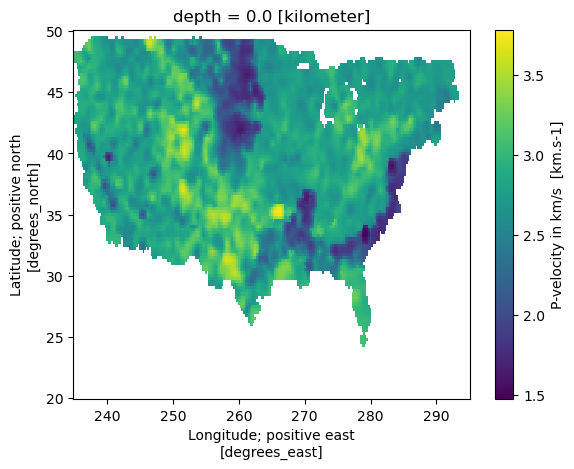

In [5]:
import xarray as xr

# Load the NetCDF dataset
file_path = r"C:/Users/gargi/Downloads/US.2016.nc"
ds = xr.open_dataset(file_path)

# Display basic info about the dataset
print(ds)

# Show all variable names
print("\nVariables in the dataset:")
print(list(ds.data_vars))

# Show coordinate names
print("\nCoordinates:")
print(list(ds.coords))

# Show a summary of each variable
for var in ds.data_vars:
    print(f"\n=== {var} ===")
    print(ds[var])

# Check dimensions
print("\nDimensions:")
print(ds.dims)

# Show one slice of data for a variable like vp
if "vp" in ds:
    ds["vp"].isel(depth=0).plot()


In [7]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin

# === Load Dataset ===
ds = xr.open_dataset(r"C:/Users/gargi/Downloads/US.2016.nc")

depths = ds['depth'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

# === Function to Write GeoTIFF ===
def save_geotiff(data, lon, lat, filename):
    # Rasterio expects top-left origin
    transform = from_origin(lon.min(), lat.max(), lon[1] - lon[0], lat[1] - lat[0])
    
    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype,
        crs="EPSG:4326",  # WGS84
        transform=transform,
    ) as dst:
        dst.write(data, 1)

# === Depths and Variables to Extract ===
target_depths = [5, 10, 50, 100]  # km
variables = {
    "vp": ds["vp"],       # P-wave
    "vs": ds["vsv"],      # S-wave (from vsv)
    "rho": ds["rho"],     # Density
}

# === Loop Over Each Depth and Variable ===
for depth_km in target_depths:
    depth_idx = np.abs(depths - depth_km).argmin()
    
    for var_name, var_data in variables.items():
        data_2d = var_data.isel(depth=depth_idx).values
        
        # Flip vertically to match GeoTIFF north-up convention
        data_flipped = np.flipud(data_2d)
        
        filename = f"US2016_{var_name}_{depth_km}km.tif"
        save_geotiff(data_flipped, lon, lat, filename)
        print(f"✅ Saved: {filename}")


✅ Saved: US2016_vp_5km.tif
✅ Saved: US2016_vs_5km.tif
✅ Saved: US2016_rho_5km.tif
✅ Saved: US2016_vp_10km.tif
✅ Saved: US2016_vs_10km.tif
✅ Saved: US2016_rho_10km.tif
✅ Saved: US2016_vp_50km.tif
✅ Saved: US2016_vs_50km.tif
✅ Saved: US2016_rho_50km.tif
✅ Saved: US2016_vp_100km.tif
✅ Saved: US2016_vs_100km.tif
✅ Saved: US2016_rho_100km.tif


In [10]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d

# === Load the Moho depth Excel file ===
moho_file_path = "C:/Users/gargi/Downloads/US_Canada_Moho_Project.xlsx"
df_moho = pd.read_excel(moho_file_path, sheet_name="US_Canada_Moho_Project")

# Rename columns for clarity
df_moho = df_moho.rename(columns={"X": "Longitude", "Y": "Latitude", "Mode Depth": "Moho_Depth"})

# Convert longitudes to 0–360 if needed
df_moho["Longitude_360"] = df_moho["Longitude"].apply(lambda x: x if x >= 0 else x + 360)

# === Load the US2016 NetCDF dataset ===
ds = xr.open_dataset(r"C:/Users/gargi/Downloads/US.2016.nc")  # Update path if running locally

# Extract coordinate arrays
latitudes = ds.latitude.values
longitudes = ds.longitude.values
depths = ds.depth.values

# Extract variables
vp_array = ds["vp"].values           # Shape: (depth, lat, lon)
vs_array = ds["vsv"].values          # Shape: (depth, lat, lon)
rho_array = ds["rho"].values         # Shape: (depth, lat, lon)

# === Create KDTree for fast lat/lon matching ===
grid_points = np.array(np.meshgrid(latitudes, longitudes)).T.reshape(-1, 2)
tree = cKDTree(grid_points)

# Prepare query points
moho_points = df_moho[["Latitude", "Longitude_360"]].values
distances, indices = tree.query(moho_points)
lat_idx, lon_idx = np.unravel_index(indices, (len(latitudes), len(longitudes)))

# === Interpolate values at Moho depth ===
moho_depths = df_moho["Moho_Depth"].values

vp_moho = []
vs_moho = []
rho_moho = []
matched_depths = []

for i in range(len(moho_depths)):
    lat_i = lat_idx[i]
    lon_i = lon_idx[i]
    
    # Extract depth profiles at that location
    vp_profile = vp_array[:, lat_i, lon_i]
    vs_profile = vs_array[:, lat_i, lon_i]
    rho_profile = rho_array[:, lat_i, lon_i]

    # Build interpolators
    vp_interp = interp1d(depths, vp_profile, bounds_error=False, fill_value='extrapolate')
    vs_interp = interp1d(depths, vs_profile, bounds_error=False, fill_value='extrapolate')
    rho_interp = interp1d(depths, rho_profile, bounds_error=False, fill_value='extrapolate')

    d_moho = moho_depths[i]

    vp_val = vp_interp(d_moho)
    vs_val = vs_interp(d_moho)
    rho_val = rho_interp(d_moho)

    # Store results
    vp_moho.append(vp_val)
    vs_moho.append(vs_val)
    rho_moho.append(rho_val)

    # Closest depth (optional, for tracking)
    matched_idx = np.abs(depths - d_moho).argmin()
    matched_depths.append(depths[matched_idx])

# === Add columns to DataFrame ===
df_moho["Matched_Depth"] = matched_depths
df_moho["Vp_Moho"] = vp_moho
df_moho["Vs_Moho"] = vs_moho
df_moho["Rho_Moho"] = rho_moho

# === Save to Excel ===
output_excel_path = "C:/Users/gargi/Downloads/Moho_Seismic_Matched_US2016.xlsx"
df_moho.to_excel(output_excel_path, index=False)

print(f"✅ New Excel file saved at: {output_excel_path}")


✅ New Excel file saved at: C:/Users/gargi/Downloads/Moho_Seismic_Matched_US2016.xlsx


Total rows: 45337
Rows with NaNs in Vp_Moho: 30975 (68.3%)


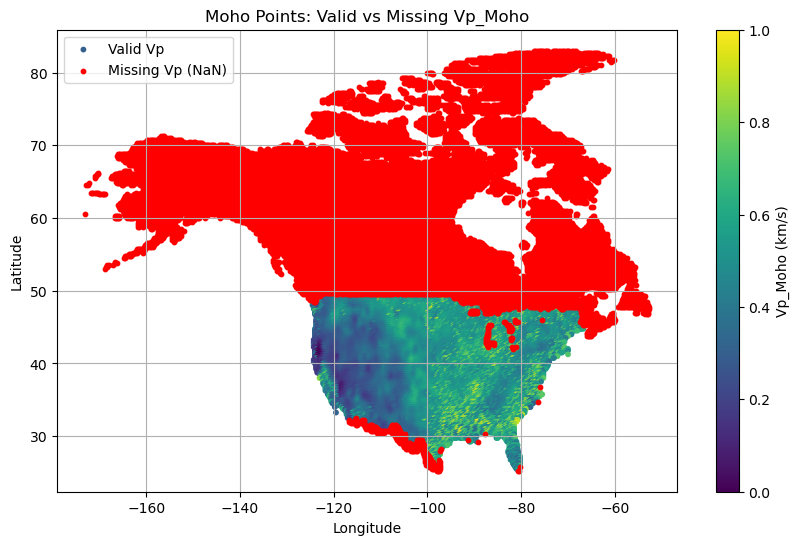

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel(r"C:/Users/gargi/Downloads/Moho_Seismic_Matched_US2016.xlsx")

# Count NaNs
n_total = len(df)
n_nans = df["Vp_Moho"].isna().sum()
print(f"Total rows: {n_total}")
print(f"Rows with NaNs in Vp_Moho: {n_nans} ({n_nans/n_total:.1%})")

# Plot valid vs. NaN data
plt.figure(figsize=(10, 6))

# Valid points
valid = df[~df["Vp_Moho"].isna()]
plt.scatter(valid["Longitude"], valid["Latitude"], c=valid["Vp_Moho"], cmap="viridis", s=10, label="Valid Vp")

# NaN points
invalid = df[df["Vp_Moho"].isna()]
plt.scatter(invalid["Longitude"], invalid["Latitude"], color="red", s=10, label="Missing Vp (NaN)")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Moho Points: Valid vs Missing Vp_Moho")
plt.legend()
plt.grid(True)
plt.colorbar(label="Vp_Moho (km/s)")
plt.show()


In [19]:
import rasterio
import numpy as np

# Function to save GeoTIFF with NoData set correctly
def save_geotiff_nodata(filename, data_grid, lon_grid, lat_grid):
    transform = rasterio.transform.from_origin(
        west=lon_grid[0],
        north=lat_grid[-1] + grid_res,
        xsize=grid_res,
        ysize=grid_res
    )

    # Set NaN cells as NoData
    data_grid[data_grid == 999] = np.nan  # Change 999 back to NaN

    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=data_grid.shape[0],
        width=data_grid.shape[1],
        count=1,
        dtype="float32",
        crs="EPSG:4326",
        transform=transform,
        nodata=np.nan  # Set NoData explicitly
    ) as dst:
        dst.write(np.flipud(data_grid.astype(np.float32)), 1)

# Re-save GeoTIFFs with NoData
save_geotiff_nodata("Vp_Moho_Clean.tif", vp_grid, lon_grid, lat_grid)
save_geotiff_nodata("Vs_Moho_Clean.tif", vs_grid, lon_grid, lat_grid)
save_geotiff_nodata("Rho_Moho_Clean.tif", rho_grid, lon_grid, lat_grid)

print("✅ GeoTIFFs saved with proper NoData values.")


✅ GeoTIFFs saved with proper NoData values.


In [22]:
import rasterio
import numpy as np

# Function to check for NaNs and extreme values
def check_geotiff(filename):
    with rasterio.open(filename) as src:
        data = src.read(1)  # Read first (only) band

        # Count NaNs
        nan_count = np.isnan(data).sum()

        # Get min and max values
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)

    print(f"File: {filename}")
    print(f"NaN Count: {nan_count}")
    print(f"Min Value: {min_val:.4f}")
    print(f"Max Value: {max_val:.4f}\n")

# Run check for all three GeoTIFFs
check_geotiff("Vp_Moho_clean.tif")
check_geotiff("Vs_Moho_clean.tif")
check_geotiff("Rho_Moho_clean.tif")


File: Vp_Moho_clean.tif
NaN Count: 5096
Min Value: 6.0941
Max Value: 8.5214

File: Vs_Moho_clean.tif
NaN Count: 5096
Min Value: 3.4838
Max Value: 4.7624

File: Rho_Moho_clean.tif
NaN Count: 5096
Min Value: 2.7104
Max Value: 3.4785



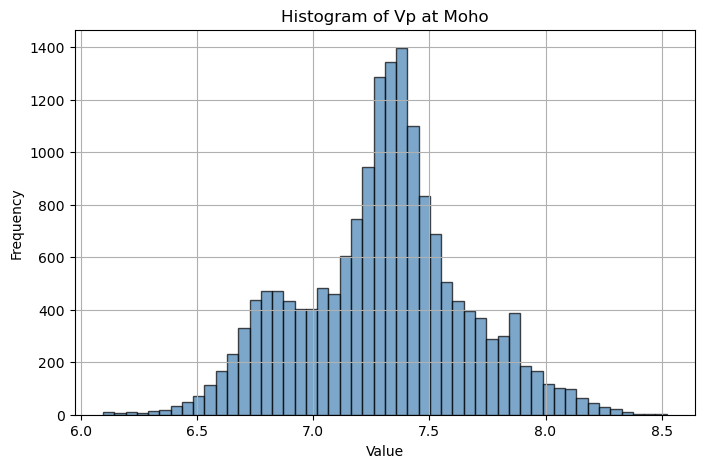

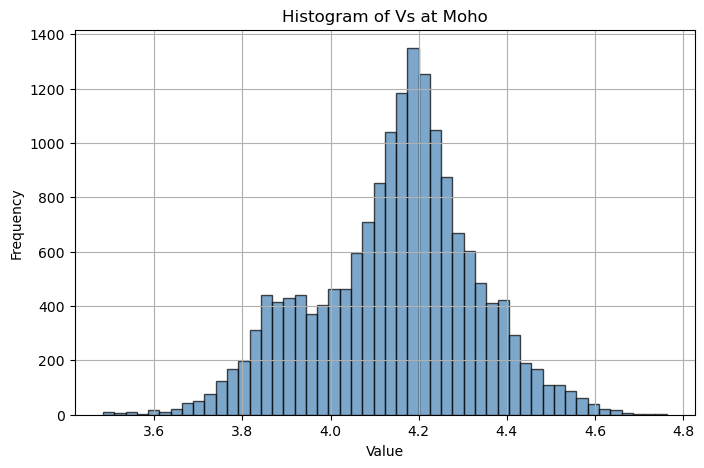

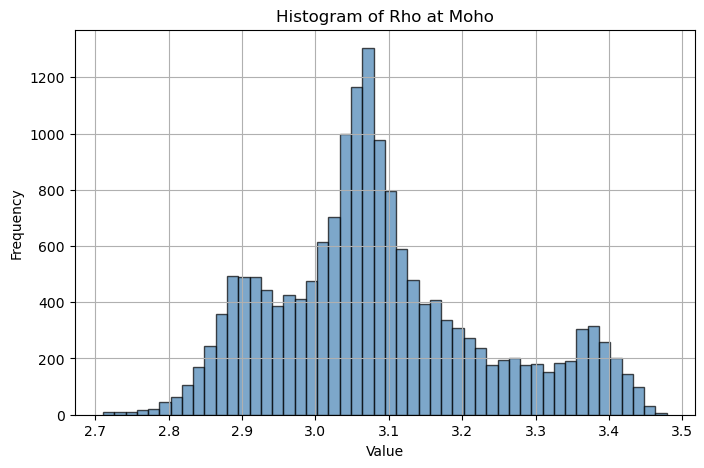

In [24]:
import matplotlib.pyplot as plt

def plot_histogram(filename, title):
    with rasterio.open(filename) as src:
        data = src.read(1)
    
    # Remove NaNs
    data = data[~np.isnan(data)]
    
    plt.figure(figsize=(8, 5))
    plt.hist(data.flatten(), bins=50, color="steelblue", edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Plot histograms
plot_histogram("Vp_Moho_clean.tif", "Vp at Moho")
plot_histogram("Vs_Moho_clean.tif", "Vs at Moho")
plot_histogram("Rho_Moho_clean.tif", "Rho at Moho")


In [25]:
def extract_value_at_point(filename, lon, lat):
    with rasterio.open(filename) as src:
        # Convert lat/lon to row/col
        row, col = src.index(lon, lat)
        value = src.read(1)[row, col]
        print(f"Value at ({lat}, {lon}) in {filename}: {value}")

# Example: Check a bright white spot in the middle of the grid
extract_value_at_point("Vp_Moho_clean.tif", -100, 35)  # Adjust lon/lat based on location
extract_value_at_point("Vs_Moho_clean.tif", -100, 35)
extract_value_at_point("Rho_Moho_clean.tif", -100, 35)


Value at (35, -100) in Vp_Moho_clean.tif: 7.432380199432373
Value at (35, -100) in Vs_Moho_clean.tif: 4.237170219421387
Value at (35, -100) in Rho_Moho_clean.tif: 3.0907199382781982


In [27]:
import rasterio
import numpy as np
import os

# Define your folder path where the TIFFs are saved (adjust if needed)
folder_path = "C:/Users/gargi/Downloads"

# Verified units based on dataset metadata
verified_units = {
    "vp": "km/s",            # P-wave velocity
    "vs": "km/s",            # S-wave velocity
    "rho": "g/cm³",          # Density
    "log_conductivity": "log(S/m)"  # Log conductivity
}

# List of TIFF files to check
tiff_files = [
    "Vp_Moho_Clean.tif", "Vs_Moho_Clean.tif", "Rho_Moho_Clean.tif",
    "log_conductivity_5km.tif", "log_conductivity_10km.tif", "log_conductivity_50km.tif", "log_conductivity_100km.tif",
    "US2016_vp_5km.tif", "US2016_vs_5km.tif", "US2016_rho_5km.tif",
    "US2016_vp_10km.tif", "US2016_vs_10km.tif", "US2016_rho_10km.tif",
    "US2016_vp_50km.tif", "US2016_vs_50km.tif", "US2016_rho_50km.tif",
    "US2016_vp_100km.tif", "US2016_vs_100km.tif", "US2016_rho_100km.tif"
]

# Function to get min, max, mean, std for each file
def analyze_geotiff(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first (only) band
        data = data[np.isfinite(data)]  # Remove NaNs & NoData values

        if data.size == 0:
            return None, None, None, None  # If all values are NaN

        return np.min(data), np.max(data), np.mean(data), np.std(data)

# Print organized results with verified units
print("\n📊 **GeoTIFF Value Ranges & Units (Verified)** 📊\n")
for tiff in tiff_files:
    file_path = os.path.join(folder_path, tiff)

    if os.path.exists(file_path):
        min_val, max_val, mean_val, std_val = analyze_geotiff(file_path)

        if min_val is None:
            print(f"⚠️ {tiff} - Contains only NoData values!\n")
            continue

        # Determine dataset type from filename and assign correct unit
        dataset_type = "Unknown"
        for key in verified_units.keys():
            if key in tiff.lower():
                dataset_type = key
                break
        unit = verified_units.get(dataset_type, "Unknown")

        print(f"📂 **{tiff}**")
        print(f"   ➝ Min: {min_val:.4f} {unit}")
        print(f"   ➝ Max: {max_val:.4f} {unit}")
        print(f"   ➝ Mean: {mean_val:.4f} {unit}")
        print(f"   ➝ Std Dev: {std_val:.4f} {unit}\n")
    else:
        print(f"❌ {tiff} - File not found!\n")



📊 **GeoTIFF Value Ranges & Units (Verified)** 📊

📂 **Vp_Moho_Clean.tif**
   ➝ Min: 6.0941 km/s
   ➝ Max: 8.5214 km/s
   ➝ Mean: 7.2978 km/s
   ➝ Std Dev: 0.3558 km/s

📂 **Vs_Moho_Clean.tif**
   ➝ Min: 3.4838 km/s
   ➝ Max: 4.7624 km/s
   ➝ Mean: 4.1459 km/s
   ➝ Std Dev: 0.1820 km/s

📂 **Rho_Moho_Clean.tif**
   ➝ Min: 2.7104 g/cm³
   ➝ Max: 3.4785 g/cm³
   ➝ Mean: 3.0852 g/cm³
   ➝ Std Dev: 0.1474 g/cm³

📂 **log_conductivity_5km.tif**
   ➝ Min: -7.0147 log(S/m)
   ➝ Max: 2.4411 log(S/m)
   ➝ Mean: -1.8726 log(S/m)
   ➝ Std Dev: 1.0983 log(S/m)

📂 **log_conductivity_10km.tif**
   ➝ Min: -7.1118 log(S/m)
   ➝ Max: 2.0012 log(S/m)
   ➝ Mean: -2.7598 log(S/m)
   ➝ Std Dev: 1.1292 log(S/m)

📂 **log_conductivity_50km.tif**
   ➝ Min: -5.3302 log(S/m)
   ➝ Max: 0.5685 log(S/m)
   ➝ Mean: -2.4062 log(S/m)
   ➝ Std Dev: 0.7417 log(S/m)

📂 **log_conductivity_100km.tif**
   ➝ Min: -4.8857 log(S/m)
   ➝ Max: 0.5648 log(S/m)
   ➝ Mean: -2.3252 log(S/m)
   ➝ Std Dev: 0.5648 log(S/m)

📂 **US2016_vp_5